# Training Whisper on huggingface

In my previous article, we learned about the new end-to-end speech recognition model developed by OpenAI: Whisper.

Today, we will go through the steps required to fine-tune a Whisper model using several Huggingface libraries. Furthermore, we will understand in detail how the Huggingface libraries take care of all the different steps under the hood, and how the model learns from the training examples.

But first let me clarify an important point: Whisper models are already trained on downstream tasks, which means that they can be used out-of-the-box to perform several tasks like language-to-language transcription, language-to-english translation, and language identification. But you will achieve better performance on specific distributions (language, domain, specific background noise, ...) if the model is fine-tuned on a a specific dataset.

If you want to learn more about the approach used, training data, model architecture and the extensive evaluation performed by the OpenAI team, [this](https://marinone94.github.io/Whisper-paper/) is the place to start! You will benefit much more from this post afterwards.

Since the scope of the article is to learn about the training process, we will fine-tune the smallest model available - [Whisper Tiny](https://huggingface.co/openai/whisper-tiny) - on the English subset of the [Fleurs](https://huggingface.co/datasets/google/fleurs) dataset. Whisper models have been trained largely on English data, so I don't expect to further improve the performance; still, it will be a good starting point to understand how the training process works, and it will allow everyone to verify the model's predictions. 

## Environment setup

To reproduce the following examples, I recommend you to setup a virtual environment. The code has been tested with the packages listed in the `requirements.txt` file, so I cannot guarantee that different packages or Python versions will run smoothly (although they will mostly will).

In [ ]:
!python3.8 -m venv venv
!source venv/bin/activate
!pip install -r requirements.txt

Let's check that the packages have been installed correctly.

In [ ]:
!pip freeze

## Training dataset

Fleurs is a dataset open-sourced by Google which contains approximately 2000 examples for each language. Each training set has around **10 hours** of supervision, and speakers of the training sets are different from the speakers of the dev and test sets.

This dataset has also been used to evaluate the translation capabilities of Whisper models, since all sentences are translated in all languages and can be matched using their ids.

Before proceeding with the training, let's take a look at the data.

In [2]:
from datasets import load_dataset

dataset = load_dataset("google/fleurs", "en_us", streaming=True)

In [4]:
dataset

{'train': <datasets.iterable_dataset.IterableDataset at 0x7f9c7571a220>,
 'validation': <datasets.iterable_dataset.IterableDataset at 0x7f9c7571a9d0>,
 'test': <datasets.iterable_dataset.IterableDataset at 0x7f9c7571c1c0>}

As you can see, the dataset contains three splits. Each split is an IterableDataset, since we have loaded it in streaming mode. This means that the dataset is not downloaded, but it is loaded on the fly when needed. This is useful when the dataset occupies too much space on the disk, or if you want to avoid waiting for the whole dataset to be downloaded. Huggingface [docs](https://huggingface.co/docs/datasets/stream) are excellent to learn more about the datasets library and the streaming mode.

But we can still explore the dataset features without downloading it. So let's have a look.

In [3]:
from pprint import pprint

features = dataset['train'].features
pprint(features)

{'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'gender': ClassLabel(names=['male', 'female', 'other'], id=None),
 'id': Value(dtype='int32', id=None),
 'lang_group_id': ClassLabel(names=['western_european_we', 'eastern_european_ee', 'central_asia_middle_north_african_cmn', 'sub_saharan_african_ssa', 'south_asian_sa', 'south_east_asian_sea', 'chinese_japanase_korean_cjk'], id=None),
 'lang_id': ClassLabel(names=['af_za', 'am_et', 'ar_eg', 'as_in', 'ast_es', 'az_az', 'be_by', 'bg_bg', 'bn_in', 'bs_ba', 'ca_es', 'ceb_ph', 'ckb_iq', 'cmn_hans_cn', 'cs_cz', 'cy_gb', 'da_dk', 'de_de', 'el_gr', 'en_us', 'es_419', 'et_ee', 'fa_ir', 'ff_sn', 'fi_fi', 'fil_ph', 'fr_fr', 'ga_ie', 'gl_es', 'gu_in', 'ha_ng', 'he_il', 'hi_in', 'hr_hr', 'hu_hu', 'hy_am', 'id_id', 'ig_ng', 'is_is', 'it_it', 'ja_jp', 'jv_id', 'ka_ge', 'kam_ke', 'kea_cv', 'kk_kz', 'km_kh', 'kn_in', 'ko_kr', 'ky_kg', 'lb_lu', 'lg_ug', 'ln_cd', 'lo_la', 'lt_lt', 'luo_ke', 'lv_lv', 'mi_nz', 'mk_mk', 'ml_in', 'mn_mn

Alright, so we can see that the dataset contains a bunch of features we could use for different purposes. To train our speech recognition model, we will use only the `audio` and `raw_transcription` features. But let's look at a sample to understand why we choose only those features. Remember that we loaded the dataset in streaming mode, so we can't access it through indexes since we don't have it in memory yet! By casting it to a list though, the data point will be loaded in memory.

In [134]:
# Get a reference to the first item of the dataset
dataset_head = dataset['train'].take(1)
# Actually download the first item and pprint it
sample = list(dataset_head)[0]
pprint(sample)


{'audio': {'array': array([ 0.        ,  0.        ,  0.        , ...,  0.00068671,
       -0.0013473 , -0.0004167 ]),
           'path': '14223464699748513050.wav',
           'sampling_rate': 16000},
 'gender': 1,
 'id': 823,
 'lang_group_id': 0,
 'lang_id': 19,
 'language': 'English',
 'num_samples': 181440,
 'path': '14223464699748513050.wav',
 'raw_transcription': 'Although most agencies are willing to take on most '
                      'regular bookings, many agents specialise in particular '
                      'types of travel, budget ranges or destinations.',
 'transcription': 'although most agencies are willing to take on most regular '
                  'bookings many agents specialise in particular types of '
                  'travel budget ranges or destinations'}
Although most agencies are willing to take on most regular bookings, many agents specialise in particular types of travel, budget ranges or destinations.


So, the `audio` feature is a dictionary containing the audio waveform stored as numpy array, the file path and the sampling rate. The `raw_transcription` feature is a string containing the transcription of the audio file. Let's listen to it.

In [9]:
print(sample["raw_transcription"])
Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

Although most agencies are willing to take on most regular bookings, many agents specialise in particular types of travel, budget ranges or destinations.


As you can hear, the audio is really clear and Whisper should perform well on this example. Let's have a look at the transcription. I will not explain each step here, as you can read all the details in my previous [article](https://marinone94.github.io/Whisper-paper/).

In [23]:
from torch.cuda import is_available as cuda_is_available
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration
)

# If you have a GPU, it will be faster...
device = "cuda" if cuda_is_available() else "cpu"

# Load processor for audio and text
# feature processor (audio) + tokenizer (text)
processor = WhisperProcessor.from_pretrained(
    "openai/whisper-tiny")

# Load model architecture and weights
model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-tiny").to(device)
model_def_max_length = model.config.max_length

# Load audio file (see previous cells)
data = sample["audio"]["array"]
sampling_rate = sample["audio"]["sampling_rate"]
print("Audio loaded. Sample rate: ", sampling_rate)

# Convert input audio to log-mel spectrogram
input_features = processor(
    data, sampling_rate=sampling_rate, return_tensors="pt").input_features.to(device)

# Get tokens to initiate transcription
# and store them in the model config.
# Under the hood, this will force the model to predict
# these tokens in the beginning of the transcription.
init_tokens = processor.get_decoder_prompt_ids(
    language="en", task="transcribe", no_timestamps=True)
model.config.forced_decoder_ids = init_tokens

# Generate transcription tokens
print("Generating transcription...")
transcription_token_ids = model.generate(
    input_features, max_new_tokens=model_def_max_length)
print("Transcription generated.")

# Decode transcription
# NOTE: input_features is a batch of one element,
# and the returned token ids are batched analogously
transcription_token_ids = transcription_token_ids[0]
whisper_transcript = processor.decode(
    transcription_token_ids, skip_special_tokens=True).strip()

# Print result and compare with reference transcript
print("Whisper transcript:\n", whisper_transcript)
reference_transcript = sample["raw_transcription"]
print("Reference transcript:\n", reference_transcript)


Audio loaded. Sample rate:  16000
Generating transcription...
Transcription generated.
Whisper transcript:
 Although most agencies are willing to take on most regular bookings, many agents specialize in particular types of travel, budget ranges or destinations.
Reference transcript:
 Although most agencies are willing to take on most regular bookings, many agents specialise in particular types of travel, budget ranges or destinations.


We can see that the generated and the reference transcripts are identical. As said, this example was quite clean and Whisper was expected to perform well on it, so we shouldn't be surprised. But how do we measure the performance of the model? It is almost time to introduce the standard evaluation metric for speech recognition: the [Word Error Rate](https://en.wikipedia.org/wiki/Word_error_rate). But before that, we should inspect the dataset a bit more. Let's load 100 random samples and look at the distribution of audio duration and transcription length (measured in number of tokens).

As the audio duration is not directly provided, we can infer it from the number of samples and the sampling rate. Let's remove the unnecessary features.

In [ ]:
cols_to_keep = ["audio", "raw_transcription", "num_samples"]
cols_to_remove = [col for col in sample.keys() if col not in cols_to_keep]
dataset = dataset.remove_columns(cols_to_remove)

In [116]:
samples = dataset['train'].shuffle().take(100)
samples.features

{'num_samples': Value(dtype='int32', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'raw_transcription': Value(dtype='string', id=None)}

In [117]:
import pandas as pd
from tqdm import tqdm

rows = [row for row in tqdm(samples)]
df = pd.DataFrame(rows, columns=list(samples.features.keys()))

100it [01:49,  1.09s/it]


In [118]:
def audio_length(ns):
    return round(ns / sampling_rate, 2)

def tokenize(text):
    return processor.tokenizer.tokenize(text)

In [119]:
df["audio_length"] = df["num_samples"].apply(audio_length)
df["tokens"] = df["raw_transcription"].apply(tokenize)
df["num_tokens"] = df["tokens"].apply(len)

In [120]:
df.head()

,num_samples,audio,raw_transcription,audio_length,tokens,num_tokens
0,122880,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Voyagers planning sex reassignment surgery abr...,7.68,"[V, oy, agers, Ġplanning, Ġsex, Ġreass, ignmen...",25
1,181440,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Although most agencies are willing to take on ...,11.34,"[Al, though, Ġmost, Ġagencies, Ġare, Ġwilling,...",35
2,131520,"{'path': None, 'array': [0.0, 0.0, -3.05175781...","Internationally, there are nearly 200 running ...",8.22,"[In, tern, ation, ally, ,, Ġ, there, Ġare, Ġne...",23
3,55680,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",An inquiry was established to investigate.,3.48,"[An, Ġinquiry, Ġwas, Ġestablished, Ġ, to, Ġinv...",8
4,146880,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",At one point a member of the mob waved the hea...,9.18,"[At, Ġone, Ġpoint, Ġa, Ġmember, Ġof, Ġ, the, Ġ...",34


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   num_samples        100 non-null    int64  
 1   audio              100 non-null    object 
 2   raw_transcription  100 non-null    object 
 3   audio_length       100 non-null    float64
 4   tokens             100 non-null    object 
 5   num_tokens         100 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 4.8+ KB


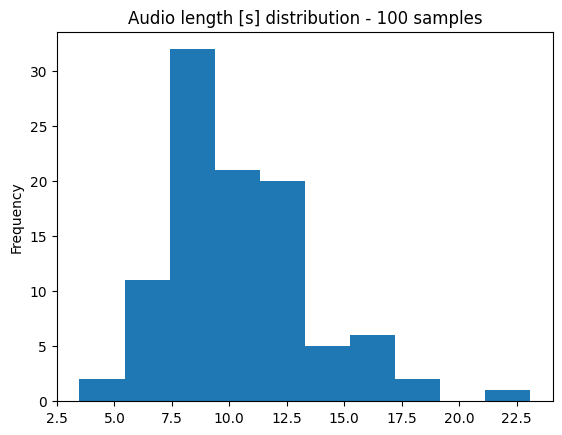

In [122]:
import matplotlib.pyplot as plt

# Plot the histogram
df.audio_length.plot(kind='hist', bins=10)

# Show the plot
plt.title(f"Audio length [s] distribution - {len(df)} samples")
plt.show()

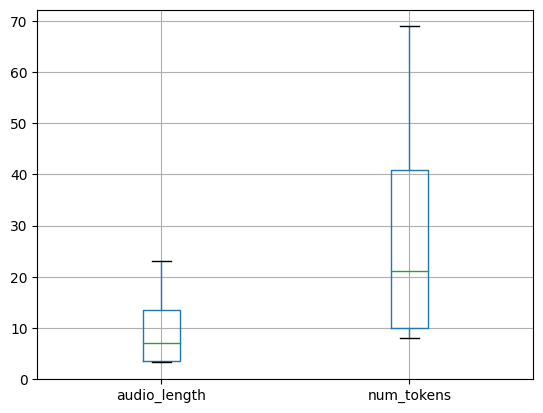

In [132]:
import altair as alt

stats_df = pd.DataFrame({
    "mean": [df.audio_length.mean(), df.num_tokens.mean()],
    "std": [df.audio_length.std(), df.num_tokens.std()],
    "min": [df.audio_length.min(), df.num_tokens.min()],
    "max": [df.audio_length.max(), df.num_tokens.max()],
}, index=["audio_length", "num_tokens"]).T
stats_df
stats_df.boxplot()
plt.show()

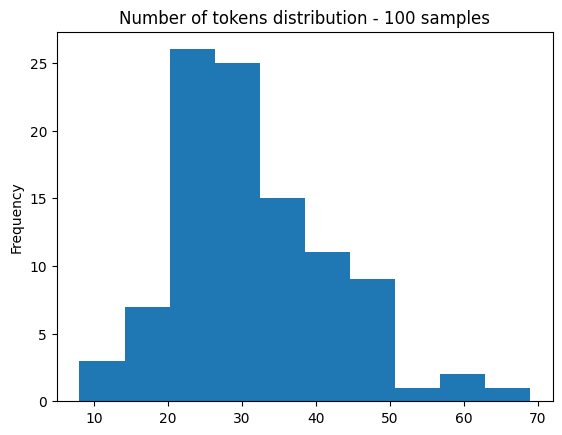

In [123]:
import matplotlib.pyplot as plt

# Plot the histogram
df.num_tokens.plot(kind='hist', bins=10)

# Show the plot
plt.title(f"Number of tokens distribution - {len(df)} samples")
plt.show()

From the plotting, we can observe that none of the randomly selected examples is longer than 30 seconds. It is relatively safe to assume then that only a few examples will be truncated during the training. Most of the samples have between 20 and 50 tokens, corresponding to audios between 5 and 15 seconds. Therefore, this dataset might not be the best to fine-tune a model which will then be used to transcribe single words. This is just to remind that we rarely have one dataset which is perfect for all the tasks we want to perform, and it is worth spending some time to understand the dataset before jumping into the training.

Last check: let's have a look the shortest and longest examples (as number of tokens of the reference transcription).

In [136]:
min_num_tokens = stats_df["num_tokens"]["min"]
max_num_tokens = stats_df["num_tokens"]["max"]
print(f"Min number of tokens: {min_num_tokens}")
print(f"Max number of tokens: {max_num_tokens}")

Min number of tokens: 8.0
Max number of tokens: 69.0


In [137]:
short_sample = df[df.num_tokens == min_num_tokens].reset_index().iloc[0]
long_sample = df[df.num_tokens == max_num_tokens].reset_index().iloc[0]

In [140]:
print(short_sample["raw_transcription"])
Audio(short_sample["audio"]["array"], rate=short_sample["audio"]["sampling_rate"])

An inquiry was established to investigate.


In [141]:
print(long_sample["raw_transcription"])
Audio(long_sample["audio"]["array"], rate=long_sample["audio"]["sampling_rate"])

A few weeks ago, after the information published by the journalist Makis Triantafylopoulos in his popular Television show "Zoungla" in Alpha TV, the member of Parliament and lawyer, Petros Mantouvalos was abdicated as members of his office had been involved in illegal graft and corruption.


In [ ]:
# This download function is used to embed the files in the blog post.
def download_audio(array, filepath):
    raise NotImplementedError("This function is not implemented yet.")